In [126]:
#Imports
import random
import geohash
import geotools
import networkx as nx
import numpy as np
import scipy.spatial as spatial
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt
%matplotlib inline

<h2>Geographic Sims</h2>

In [87]:
def generate_nodes(N,pop_min_max,lat_min_max,lon_min_max):
    '''Generate a normally random dictionary of N geographic nodes with data dictionary of node population and lat/lon coords
    N = numer of nodes
    pop_min_max = tuple of [min,max] population thresholds
    lat_min_max = tuple of [min,max] latitude thresholds
    lon_min_max = tuple of [min,max] longitude thresholds
    '''
    
    node_dict = {}
    for node in range(N):
        lat = random.uniform(*lat_min_max)
        lon = random.uniform(*lon_min_max)
        gh = geohash.encode(lat,lon)
        node_dict[gh] = {'pop':random.randint(*pop_min_max),
                           'lat':lat,
                           'lon':lon,
                           'geohash':gh
                          }
    return node_dict

def generate_network(node_dict,max_connect_dist,link_prob):
    seen_edges = []
    G = nx.Graph()
    for node,data in node_dict.items():
        if node not in G.nodes():
            G.add_node(node,attr_dict=data)
        possible_connections = geotools.get_close_ghs(data['geohash'],G.nodes(),max_connect_dist)
        for connection_node in possible_connections:
            edge_hash = ''.join(sorted([node,connection_node]))
            if random.random() <= link_prob and edge_hash not in seen_edges:
                G.add_edge(node,connection_node)
            seen_edges.append(edge_hash)
    return G

In [85]:
node_dict = generate_nodes(10,[10,100],[30.,70],[40,50])
G = generate_network(node_dict,0.1,0.1)

tj89vxxhz4ggtj89vxxhz4gg


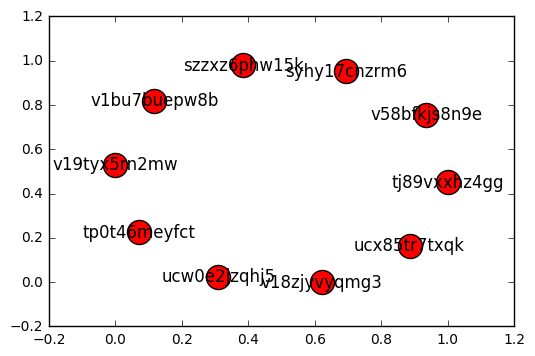

In [86]:
nx.draw_networkx(G)

<h2>Distance Weighted Random Geometric Graph Sims</h2>

In [141]:
def link_prob_vs_distance(distance,max_distance,funct='unit'):
    if funct == 'unit':
        if distance <= max_distance:
            return 1
        else:
            return 0
    elif funct == 'linear':
        return 1 - distance/max_distance

def distance_weighted_RGG(N,max_distance,funct = 'unit',dimensions=2):
    G = nx.Graph()
    pos_points = []
    for node in range(N):
        pos = [random.random() for dim in range(dimensions)]
        G.add_node(node,pos=pos)
        pos_points.append(pos)
    point_tree = spatial.cKDTree(pos_points)
    for node,data in G.nodes_iter(data=True):
        close_nodes = [nd for nd in point_tree.query_ball_point(data['pos'],max_distance) if nd != node]
        for connect_node in close_nodes:
            dist = spatial.distance.euclidean(data['pos'],G.node[connect_node]['pos'])
            link_prob = link_prob_vs_distance(dist,max_distance,funct)
            if random.random() <= link_prob:
                G.add_edge(node,connect_node)
    return G

In [142]:
G = distance_weighted_RGG(200,0.125)

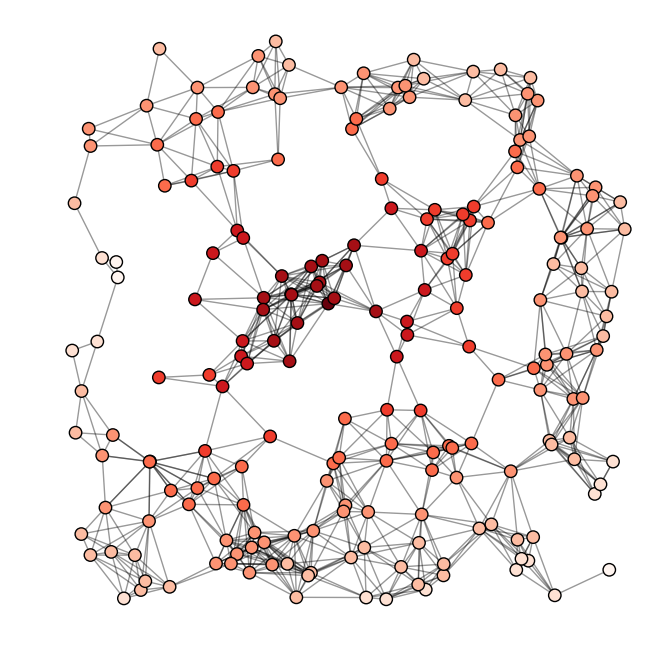

In [143]:
#https://networkx.github.io/documentation/networkx-1.9/examples/drawing/random_geometric_graph.html
# position is stored as node attribute data for random_geometric_graph
pos=nx.get_node_attributes(G,'pos')

# find node near center (0.5,0.5)
dmin=1
ncenter=0
for n in pos:
    x,y=pos[n]
    d=(x-0.5)**2+(y-0.5)**2
    if d<dmin:
        ncenter=n
        dmin=d

# color by path length from node near center
p=nx.single_source_shortest_path_length(G,ncenter)

plt.figure(figsize=(8,8))
nx.draw_networkx_edges(G,pos,nodelist=[ncenter],alpha=0.4)
nx.draw_networkx_nodes(G,pos,nodelist=p.keys(),
                       node_size=80,
                       node_color=list(p.values()),
                       cmap=plt.cm.Reds_r)

plt.xlim(-0.05,1.05)
plt.ylim(-0.05,1.05)
plt.axis('off')
plt.show()